In [1]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler

from concurrent_functions import get_q2_concurrent, calculate_q2_for_combination
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

# Get Key Files

### Full Multi-Task Data
Here, there is one row per stage. Each row explains how a particular team did on a particular task with a particular complexity.

In [3]:
# full multi-task data
full_multi_task_data = pd.read_csv('../tpm-data/raw_data/full_multi_task_data.csv').rename(columns={"task": "task_name"})
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)
full_multi_task_data.head()

,task_name,complexity,stageId,playerCount,score
0,Writing Story,Medium,22bJZWfgB3gfKXY6A,6,100.000000
1,Writing Story,Low,22wFrSqgf8ESM8pNY,3,100.000000
2,Divergent Association,Medium,24uBQrHu4jKFgGQ24,1,83.248037
3,Moral Reasoning,High,26RnwcdY842ZGSQtT,3,50.000000
4,Room Assignment,High,28b6Y5xQDcrdFZK2h,1,88.659794


### Task Map

In [4]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [5]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole"
}

In [6]:
# make the names match
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

## Get Team Data

### SET WHAT YOU ARE GROUPING BY HERE

In [7]:
GROUPING_COLS = ["task_name", "complexity", "playerCount"]
# GROUPING_COLS = ["task_name", "playerCount"]
# GROUPING_COLS = ["task_name"]

In [8]:
complexity_columns = ["High", "Low", "Medium"]

full_multi_task_data["team"] = np.where(full_multi_task_data["playerCount"] > 1, True, False)
team_multi_task_data = full_multi_task_data[full_multi_task_data["team"] == True]
grouped_performance_by_task = pd.DataFrame(team_multi_task_data.groupby(GROUPING_COLS)["score"].agg("mean")).reset_index()

if "complexity" in GROUPING_COLS:
    grouped_performance_by_task = pd.get_dummies(grouped_performance_by_task, columns = ["complexity"]).rename(columns = {"complexity_High": "High", "complexity_Low": "Low", "complexity_Medium": "Medium"})
    grouped_performance_by_task[complexity_columns] = grouped_performance_by_task[complexity_columns].astype(int)

### This is main data DF --
grouped_performance_with_task_cols = pd.merge(left = grouped_performance_by_task, right = task_map, on = "task_name", how = "left")

### Stage-based data

For teams, here we get information on:
- Player Composition
- Communication (chat) features

In [9]:
# read in some scores from one of our pickle files
# NOTE: the noncumulative version slices by the STAGE, which means we get the discussion relevant to the task complexity as well
with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
	stage_based_data = pickle.load(cleaned_pickle_file)

In [10]:
stage_based_data.data.loc[:, "task_name"] = stage_based_data.data["task"].replace(task_name_mapping)
stage_based_data.data.drop("task", axis =1, inplace=True)
targets = stage_based_data.dvs
tasks = stage_based_data.task_name

# Get a sense of how many observations we have

In [11]:
full_multi_task_data.groupby(["task_name", "complexity", "playerCount"]).size().reset_index(name='num_observations').head(30)

,task_name,complexity,playerCount,num_observations
0,Allocating resources to programs,High,1,50
1,Allocating resources to programs,High,3,31
2,Allocating resources to programs,High,6,26
3,Allocating resources to programs,Low,1,50
4,Allocating resources to programs,Low,3,31
5,Allocating resources to programs,Low,6,26
6,Allocating resources to programs,Medium,1,50
7,Allocating resources to programs,Medium,3,31
8,Allocating resources to programs,Medium,6,26
9,Divergent Association Task,High,1,29


# Calculate Synergy
> take score and for every team choose a random group of individuals of the same team size, then from that group select the best individual and a random individual.

> Synergy is then:

> strong if the team is better than the best individual

> weak if the team is not better than the best individual but better than the random one


In [12]:
individual_multi_task_data = full_multi_task_data[full_multi_task_data["team"]==False]
individual_multi_task_data.head()

,task_name,complexity,stageId,playerCount,score,team
2,Divergent Association Task,Medium,24uBQrHu4jKFgGQ24,1,83.248037,False
4,Room assignment task,High,28b6Y5xQDcrdFZK2h,1,88.659794,False
5,"Wolf, goat and cabbage transfer",High,297T4k8D3YuCqKYgk,1,0.000000,False
6,"Wolf, goat and cabbage transfer",Medium,2AnaRvyyBhKYYz3bv,1,43.000000,False
8,Allocating resources to programs,Medium,2DLuipD5F9zFmC3BP,1,90.000000,False


In [13]:
def get_nominal_team(task_name, playerCount, complexity = None):
    if complexity is not None:
        individuals_for_task_and_complexity = individual_multi_task_data[(individual_multi_task_data["task_name"] == task_name) & (individual_multi_task_data["complexity"] == complexity)]
    else:
        individuals_for_task_and_complexity = individual_multi_task_data[(individual_multi_task_data["task_name"] == task_name)]
    return individuals_for_task_and_complexity.sample(n = playerCount, replace = True)

In [14]:
def get_best_and_random_individual(task_name, playerCount, complexity):
    nominal_team_scores = get_nominal_team(task_name, playerCount, complexity)["score"]
    return(np.max(nominal_team_scores), random.choice(list(nominal_team_scores)))

In [15]:
random.seed(19104)

def get_synergy_for_groups(complexity = True, playerCount = True):
    grouped_performance_with_task_cols["strong_synergy"] = np.zeros(len(grouped_performance_with_task_cols))
    grouped_performance_with_task_cols["weak_synergy"] = np.zeros(len(grouped_performance_with_task_cols))

    for i, row in grouped_performance_with_task_cols.iterrows():

        task_name = row["task_name"]

        # If we grouped by the complexity level and playerCount
        if(complexity):
            if row["High"] == 1:
                complexity_value = "High"
            elif row["Medium"] == 1:
                complexity_value = "Medium"
            else:
                complexity_value = "Low"
        
        if(playerCount):
            playerCount_value = row["playerCount"]
        
        average_team_score = row["score"]

        best_individual_scores = []
        random_individual_scores = []
        
        # for each task x complexity x playerCount combination, we sample 1,000 times
        N_BOOT = 1000
        if(playerCount == False):
            task_props = pd.DataFrame(team_multi_task_data.groupby("task_name").apply(lambda x: x.groupby("playerCount").size() / len(x))).reset_index()
            prop_3 = float(task_props[task_props["task_name"]==task_name].loc[:,3].iloc[0])
            # we randomly choose 3 or 6 to simulate the real teams, if we don't take playerCount into consideration
            # weight this by the proportion of 3 or 6 in the real data
            playerCount_values = random.choices([3,6], weights = [prop_3, 1-prop_3], k = N_BOOT)
        if(complexity==False):
            complexity_props = pd.DataFrame(team_multi_task_data.groupby("task_name").apply(lambda x: x.groupby("complexity").size() / len(x))).reset_index()
            prop_hi = float(complexity_props[complexity_props["task_name"]==task_name]["High"].iloc[0])
            prop_med = float(complexity_props[complexity_props["task_name"]==task_name]["Medium"].iloc[0])
            prop_lo = float(complexity_props[complexity_props["task_name"]==task_name]["Low"].iloc[0])
            # we randomly select a complexity value in this case
            # weight this by the complexity values in the real data
            complexity_values = random.choices(["High", "Medium", "Low"], weights = [prop_hi, prop_med, prop_lo], k = N_BOOT)

        for j in range(N_BOOT): # bootstrap 1,000 times
            if(playerCount == False):
                playerCount_value = playerCount_values[j]
            if(complexity == False):
                complexity_value = complexity_values[j]
            best_score, random_score = get_best_and_random_individual(task_name, playerCount_value, complexity_value)
            best_individual_scores.append(best_score)
            random_individual_scores.append(random_score)

        # update the original dataframe
        grouped_performance_with_task_cols.loc[i, "strong_synergy"] = average_team_score / np.mean(best_individual_scores)
        grouped_performance_with_task_cols.loc[i, "weak_synergy"] = average_team_score / np.mean(random_individual_scores)

In [16]:
complexity = True if "complexity" in GROUPING_COLS else False
playerCount = True if "playerCount" in GROUPING_COLS else False

get_synergy_for_groups(complexity = complexity, playerCount=playerCount)

### Playing around with other ways to synethesize nominal teams
Using Mark's method of generating 1,000 bootstrapped counterfactual teams *per team in the multi-task dataset*

In [17]:
# random.seed(19104)

# team_multi_task_data_with_bootstrapped_synergy = team_multi_task_data.copy()

# def get_synergy_for_groups_mark():
#     team_multi_task_data_with_bootstrapped_synergy["strong_synergy"] = np.zeros(len(team_multi_task_data_with_bootstrapped_synergy))
#     team_multi_task_data_with_bootstrapped_synergy["weak_synergy"] = np.zeros(len(team_multi_task_data_with_bootstrapped_synergy))

#     for i, row in team_multi_task_data.iterrows():

#         # each row is a single team with a task and complexity level
#         task_name = row["task_name"]
#         complexity = row["complexity"]
#         playerCount = row["playerCount"]
        
#         score = row["score"]

#         best_individual_scores = []
#         random_individual_scores = []
        
#         # for each team, we sample 1,000 times
#         N_BOOT = 1000
       
#         for j in range(N_BOOT): # bootstrap 1,000 times
#             best_score, random_score = get_best_and_random_individual(task_name, playerCount, complexity)
#             best_individual_scores.append(best_score)
#             random_individual_scores.append(random_score)

#         # update the original dataframe
#         team_multi_task_data_with_bootstrapped_synergy.loc[i, "strong_synergy"] = score / np.mean(best_individual_scores)
#         team_multi_task_data_with_bootstrapped_synergy.loc[i, "weak_synergy"] = score / np.mean(random_individual_scores)

# get_synergy_for_groups_mark()
# mark_aggregations = team_multi_task_data_with_bootstrapped_synergy.groupby("task_name").agg({"strong_synergy": "mean", "weak_synergy": "mean"}).reset_index()
# mark_aggregations = mark_aggregations.rename(columns={"strong_synergy": "strong_synergy_mark", "weak_synergy": "weak_synergy_mark"})
# grouped_performance_with_task_cols = grouped_performance_with_task_cols.merge(mark_aggregations, on = "task_name")

In [18]:
# grouped_performance_with_task_cols.to_csv('./task_map_explorations_with_multitask/grouped_performance_by_task.csv')

## Exploratory Heatmap Plots

In [19]:
task_cols = task_map.drop("task_name", axis = 1).columns

In [20]:
def plot_correlation_heatmap(correlation_matrix, y_cols, feature_name):
    # sort by average absolute value
    correlation_matrix = np.array(correlation_matrix)  # Ensure correlation_matrix is a NumPy array
    average_abs_values = np.mean(np.abs(correlation_matrix), axis=0)
    mapping = {idx: value for idx, value in enumerate(average_abs_values)}
    sorted_mapping = sorted(mapping.items(), key=lambda x: x[1], reverse=True)
    sorted_correlation_matrix = correlation_matrix[:, [idx for idx, _ in sorted_mapping]]

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(sorted_correlation_matrix)

    ax.set_xticks(np.arange(len(task_cols)))
    ax.set_xticklabels(task_cols, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(y_cols)), labels=y_cols)

    ax.set_title("Correlation Between " + feature_name + " & Task Feature")

    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink=0.6)
    cbar.set_label('Correlation')

    for i in range(sorted_correlation_matrix.shape[0]):
        for j in range(sorted_correlation_matrix.shape[1]):
            value = sorted_correlation_matrix[i][j]
            color = 'black' if value >= 0 else 'red'
            ax.text(j, i, f'{value:.2f}', ha="center", va="center", color=color, fontsize=12)

    fig.tight_layout()
    plt.show()


In [21]:
def get_correlations_per_task_complexity(dv, dv_label):    
    dv_to_task_correlation = []

    for complexity in ["Low", "Medium", "High"]:
        dv_by_task_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
        within_complexity_arr = []
        for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
            correlation = np.corrcoef(dv_by_task_for_complexity[dv], dv_by_task_for_complexity[col])[0][1]
            within_complexity_arr.append(correlation)

        dv_to_task_correlation.append(within_complexity_arr)
    plot_correlation_heatmap(dv_to_task_correlation, complexity_columns, dv_label)

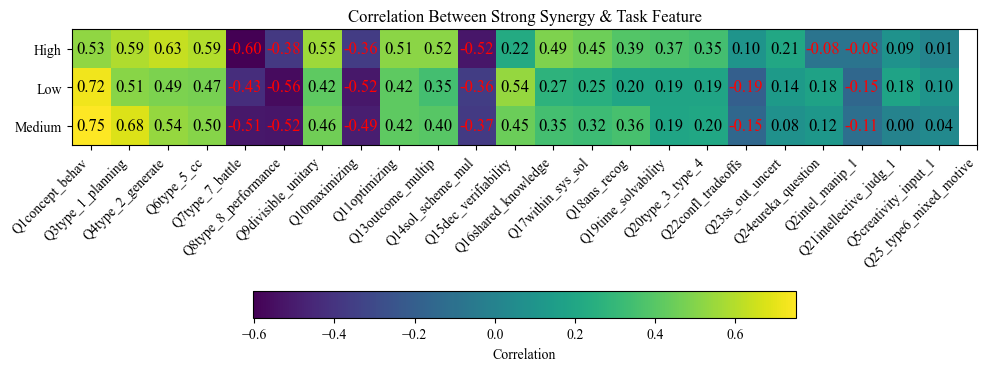

In [22]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("strong_synergy", "Strong Synergy")

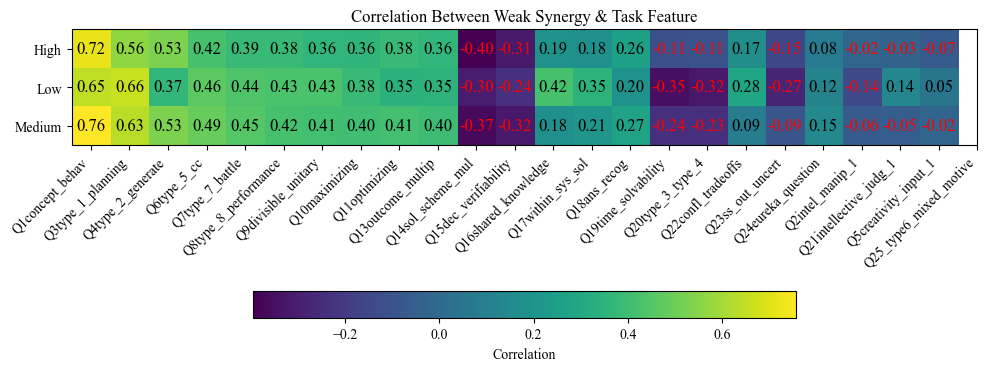

In [23]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("weak_synergy", "Weak Synergy")

## Add in Communication Features

In [24]:
comms_features = stage_based_data.data.groupby(GROUPING_COLS)[["gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]].agg("mean").reset_index()
overlapping_columns = set(comms_features.columns).intersection(grouped_performance_with_task_cols.columns)
comms_features = comms_features.drop(list(overlapping_columns), axis = 1)
grouped_performance_with_task_cols = pd.concat([grouped_performance_with_task_cols,comms_features], axis = 1)

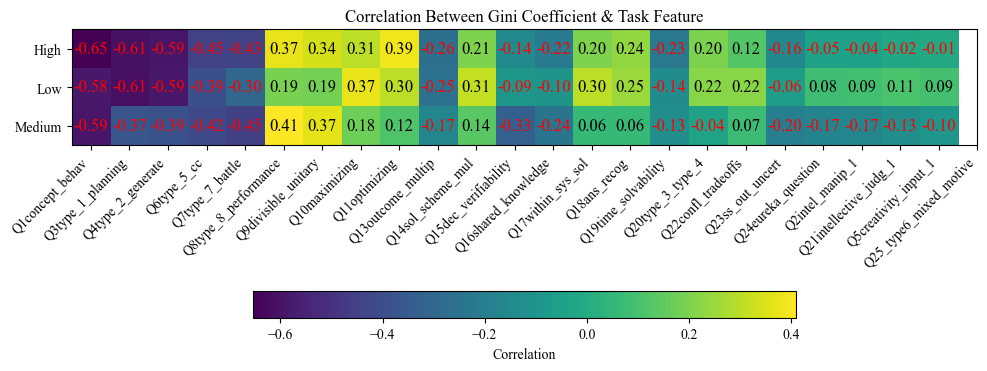

In [25]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("gini_coefficient_sum_num_messages", "Gini Coefficient")

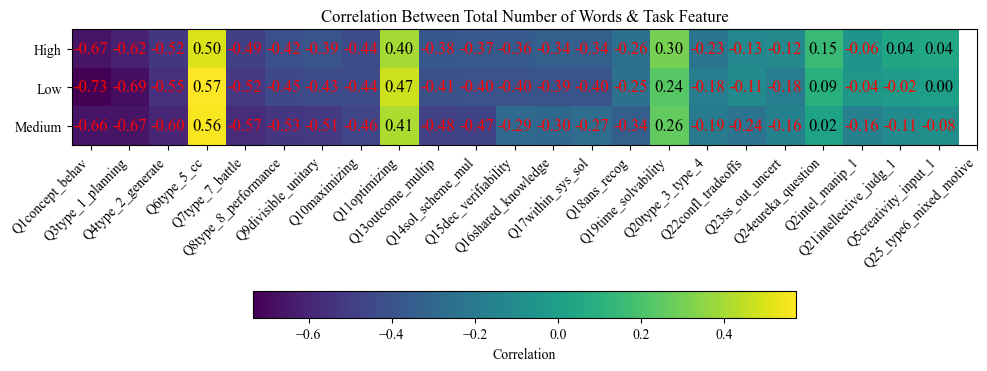

In [26]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("sum_num_words", "Total Number of Words")

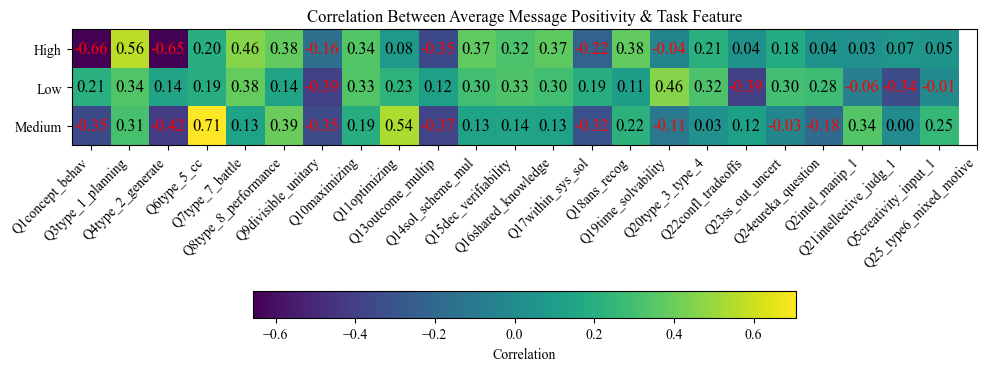

In [27]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("average_positive_bert", "Average Message Positivity")

## Recreation of PCA Plot (Figure 4) with Real Data

In [28]:
task_cols_to_use = task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis = 1).columns

In [29]:
numeric_columns = [col for col in grouped_performance_with_task_cols.columns if (grouped_performance_with_task_cols[col].dtype == "int64" or grouped_performance_with_task_cols[col].dtype == "float64")]

In [30]:
grouped_avg_all_tasks = grouped_performance_with_task_cols.groupby("task_name")[numeric_columns].agg("mean").reset_index()

In [31]:
# Normalize task columns
normalized_df = grouped_avg_all_tasks.copy()
normalized_df[task_cols_to_use] = normalized_df[task_cols_to_use].transform(lambda x: (x - x.mean()) / x.std())

pca = PCA(n_components=2)
pca_for_multitask_data = pca.fit_transform(normalized_df[task_cols_to_use])

In [32]:
pca_df = pd.DataFrame(data=pca_for_multitask_data, columns=["PC1", "PC2"])

In [33]:
# dependent variables of interest
pca_df["synergy"] = grouped_avg_all_tasks["strong_synergy"]
pca_df["gini_coefficient"] = grouped_avg_all_tasks["gini_coefficient_sum_num_messages"]
pca_df["total_words"] = grouped_avg_all_tasks["sum_num_words"]
pca_df["average_positivity"] = grouped_avg_all_tasks["average_positive_bert"]

# concatenate task names so that they can be included as labels
pca_df = pd.concat([pca_df, grouped_avg_all_tasks["task_name"]], axis=1)

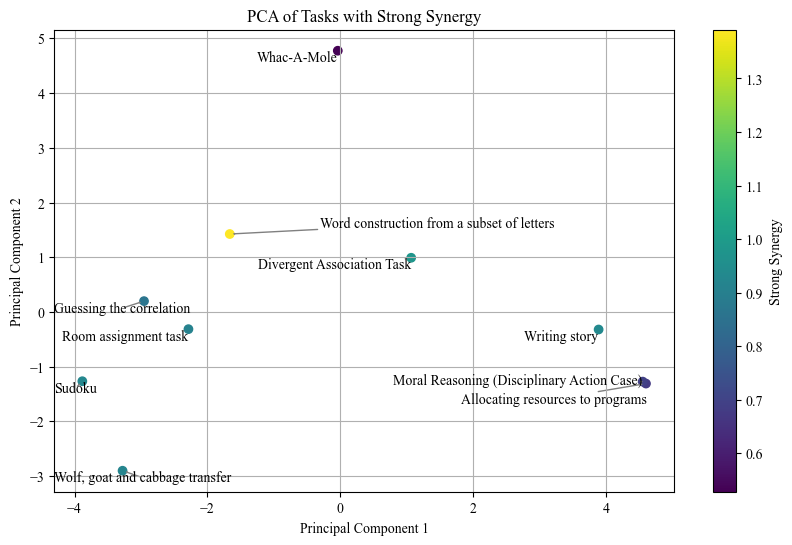

In [34]:
def plot_pca_scatter_with_labels(pca_df, dv, dv_label):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df[dv])

    plt.title("PCA of Tasks with " + dv_label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    cbar = plt.colorbar(scatter, label=dv_label)

    texts = []
    for i, txt in enumerate(pca_df["task_name"]):
        texts.append(plt.text(pca_df["PC1"].iloc[i], pca_df["PC2"].iloc[i], txt, ha='left'))

    # adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.grid(True)

    plt.show()

plot_pca_scatter_with_labels(pca_df, dv = "synergy", dv_label="Strong Synergy")

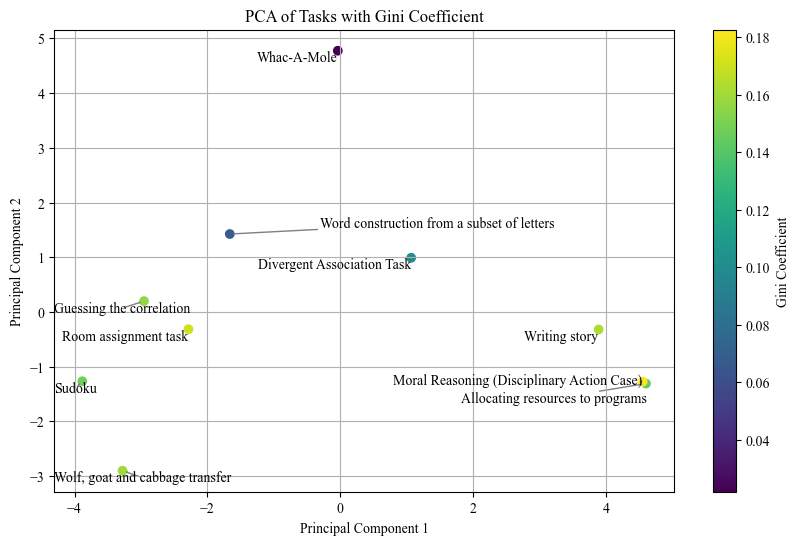

In [35]:
plot_pca_scatter_with_labels(pca_df, dv = "gini_coefficient", dv_label="Gini Coefficient")

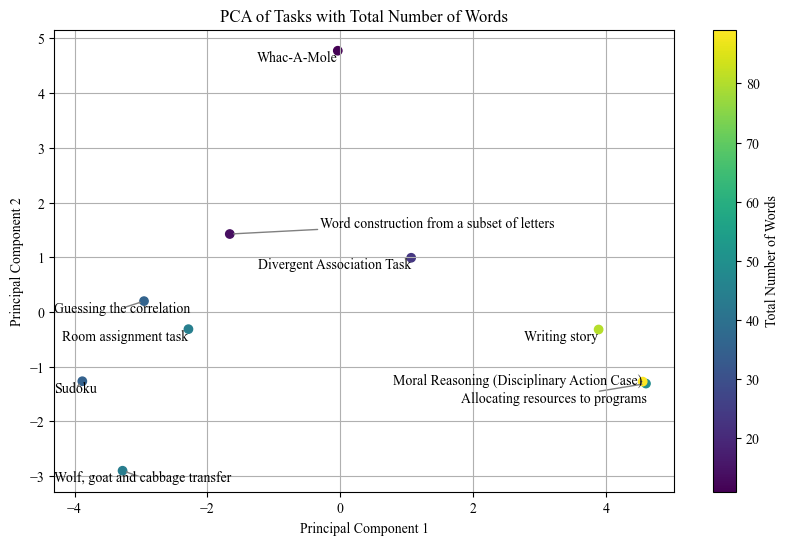

In [36]:
plot_pca_scatter_with_labels(pca_df, dv = "total_words", dv_label="Total Number of Words")

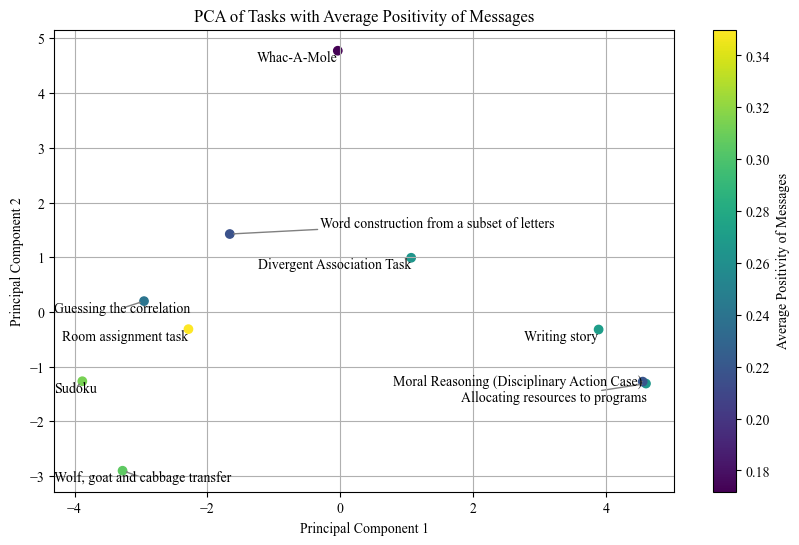

In [37]:
plot_pca_scatter_with_labels(pca_df, dv = "average_positivity", dv_label="Average Positivity of Messages")

# Regression of Features
> Try training a logistic regression model on each feature individually and ranking the features based on their performance in predicting the different outcomes. This is similar to the correlation exercise but more on predictive value.

In [38]:
if "complexity" in GROUPING_COLS and "playerCount" in GROUPING_COLS:   
    regression_covariates_task_and_complexity = list(task_cols_to_use) + complexity_columns + ["playerCount"]

    # standardize iv'set
    regression_covariates_task_and_complexity_standardized = [col + "_standardized" for col in regression_covariates_task_and_complexity]
    grouped_performance_with_task_cols[regression_covariates_task_and_complexity_standardized] = StandardScaler().fit_transform(grouped_performance_with_task_cols[regression_covariates_task_and_complexity])
        
    # standardize dv's
    dv_cols = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]
    standardized_colnames = [col + "_standardized" for col in dv_cols]
    grouped_performance_with_task_cols[standardized_colnames] = StandardScaler().fit_transform(grouped_performance_with_task_cols[dv_cols])


In [39]:
if "complexity" in GROUPING_COLS:
    strong_synergy_lm = sm.OLS(endog= grouped_performance_with_task_cols["strong_synergy_standardized"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity_standardized])).fit()
    weak_synergy_lm = sm.OLS(endog= grouped_performance_with_task_cols["weak_synergy_standardized"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity_standardized])).fit()
    gini_coefficient_lm = sm.OLS(endog= grouped_performance_with_task_cols["gini_coefficient_sum_num_messages_standardized"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity_standardized])).fit()
    sum_words_lm = sm.OLS(endog= grouped_performance_with_task_cols["sum_num_words_standardized"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity_standardized])).fit()
    positivity_lm = sm.OLS(endog= grouped_performance_with_task_cols["average_positive_bert_standardized"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity_standardized])).fit()

    models = [strong_synergy_lm, weak_synergy_lm, gini_coefficient_lm, sum_words_lm, positivity_lm]
    stargazer = Stargazer(models)
    stargazer.custom_columns(['Strong Synergy', 'Weak Synergy', 'Gini Coefficient', 'Total Number of Words', 'Average Positivity of Messages'], [1, 1, 1, 1, 1])

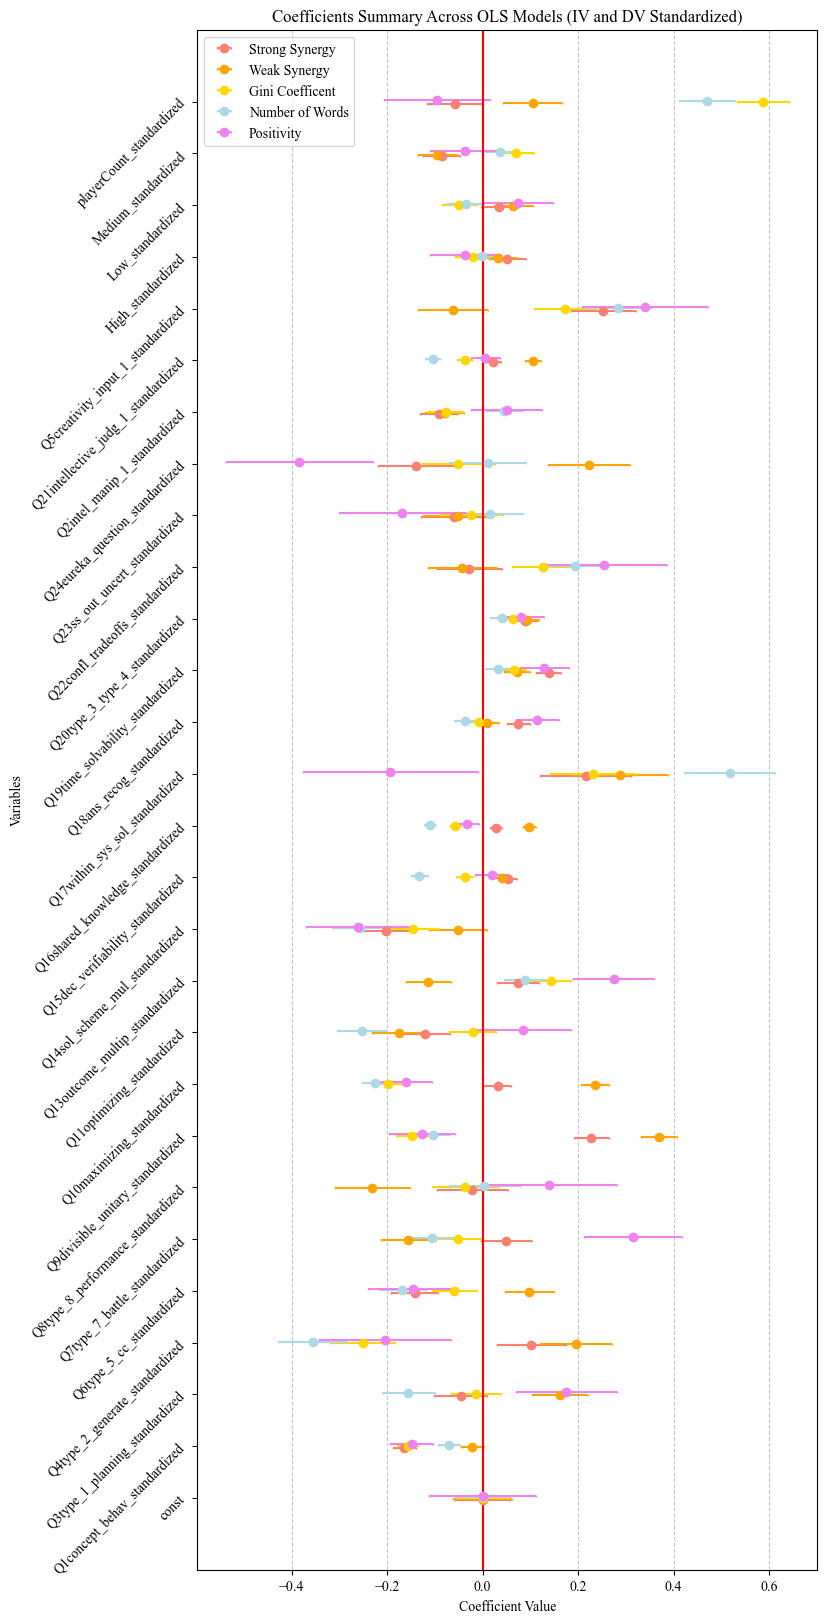

In [40]:
if "complexity" in GROUPING_COLS:
    # plot strong and weak synergy only
    # models = [strong_synergy_lm, weak_synergy_lm]
    # model_names = ["Strong Synergy", "Weak Synergy"]
    # colors = ['salmon', 'lightblue']

    # plot all
    model_names = ["Strong Synergy", "Weak Synergy", "Gini Coefficent", "Number of Words", "Positivity"]
    colors = ['salmon', 'orange', 'gold', 'lightblue', 'violet']

    # Create a DataFrame to organize the parameters for easier manipulation
    params_df = pd.DataFrame([model.params for model in models], index=model_names)
    stderr_df = pd.DataFrame([model.bse for model in models], index=model_names)

    fig, ax = plt.subplots(figsize=(8, 20))
    y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

    for i, model_name in enumerate(model_names):
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]

        plt.errorbar(means, y_positions + i * 0.2, xerr=errors, fmt='o', label=f'{model_name}', color=colors[i], capsize=1)

    ax.set_title('Coefficients Summary Across OLS Models (IV and DV Standardized)')
    ax.set_xlabel('Coefficient Value') 
    ax.set_ylabel('Variables')  
    ax.set_yticks(y_positions + (len(models) - 1) * 0.2 / 2)  
    ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
    ax.grid(axis='x', linestyle='--', alpha=0.7)  
    ax.legend()

    plt.axvline(x=0, color='r', linestyle='-') 
    plt.show()

In [41]:
def plot_q2_heatmap(q2_matrix, y_cols, feature_name):
    q2_matrix = np.array(q2_matrix)  # Ensure correlation_matrix is a NumPy array
    average_abs_values = np.mean(np.abs(q2_matrix), axis=0)
    mapping = {idx: value for idx, value in enumerate(average_abs_values)}
    sorted_mapping = sorted(mapping.items(), key=lambda x: x[1], reverse=True)
    sorted_q2_matrix = q2_matrix[:, [idx for idx, _ in sorted_mapping]]
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(sorted_q2_matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(task_cols)))
    ax.set_xticklabels(task_cols, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(y_cols)), labels=y_cols)

    ax.set_title("Q^2 for Single Variate Between " + feature_name + " & Task Feature")

    # Add shorter and horizontal colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink = 0.6)
    cbar.set_label('Q^2')

    for i in range(sorted_q2_matrix.shape[0]):
        for j in range(sorted_q2_matrix.shape[1]):
            value = sorted_q2_matrix[i][j]
            color = 'black' if value >= 0 else 'red'
            ax.text(j, i, f'{value:.2f}', ha="center", va="center", color=color, fontsize=12)

    fig.tight_layout()
    plt.show()

In [42]:
def get_q2(y, x):
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    for i in range(len(y)):
        y_test = y.iloc[[i]]
        x_test = x.iloc[[i]]
        y_train = y.drop(index=y.index[i]).reset_index(drop=True)
        x_train = x.drop(index=x.index[i]).reset_index(drop=True)
        
        if len(x_train) == 0:
            # Skip iteration if the training set is empty after dropping the row
            continue

        if(isinstance(x, pd.Series)):
            x_train_array = np.asarray(x_train).reshape(-1, 1)
        else:
            x_train_array = np.asarray(x_train)
        y_train_array = np.asarray(y_train).reshape(-1, 1)

        if(isinstance(x, pd.Series)):
            x_test_array = np.asarray(x_test).reshape(-1, 1)  # Ensure x_test is 2D
        else:
            x_test_array = np.asarray(x_test)
        
        y_test_array = np.asarray(y_test).reshape(-1, 1)
        fitted_model = LinearRegression().fit(X=x_train_array, y=y_train_array)

        # save prediction error
        prediction = fitted_model.predict(x_test_array)[0]
        squared_model_prediction_errors.append((y_test_array - prediction) ** 2)

        # save total error for this fold
        squared_average_prediction_errors.append((y_test_array - np.mean(y_train_array)) ** 2)

    return 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))

In [43]:
def get_q2_per_task_complexity(dv, dv_label):    
    dv_to_task_q2 = []

    for complexity in ["Low", "Medium", "High"]:
        dv_by_task_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
        within_complexity_arr = []
        for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
            q2 = get_q2(dv_by_task_for_complexity[dv], dv_by_task_for_complexity[[col] + ["playerCount"]]) # add controls for playerCount
            within_complexity_arr.append(q2)

        dv_to_task_q2.append(within_complexity_arr)
    plot_q2_heatmap(dv_to_task_q2, complexity_columns, dv_label)

#### Recreating part of Mark's Data
test_task = "Writing Story"

test_feature = "Q5creativity_input_1"

test_synergy_type = "strong"

test_playerCount = c(6)

test_complexity = c("High") #c("High","Medium","Low")

model_specification = synergy_ratio ~  feature_value

In [44]:
# df_filtered = grouped_performance_with_task_cols[(grouped_performance_with_task_cols['complexity'] == "High") & (grouped_performance_with_task_cols['playerCount'] == 6)]

# df_result = pd.DataFrame(columns=["feature_name", "q2"])
# for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
#     q2 = get_q2(df_filtered["strong_synergy"], df_filtered[col])
#     df_result = pd.concat([df_result, pd.DataFrame({"feature_name": [col], "q2": [q2]})])

# df_result.sort_values("q2", ascending=False)

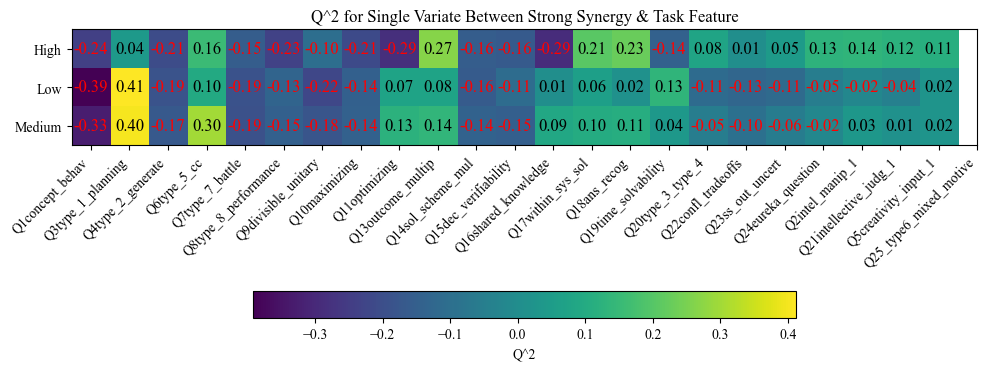

In [45]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("strong_synergy", "Strong Synergy")

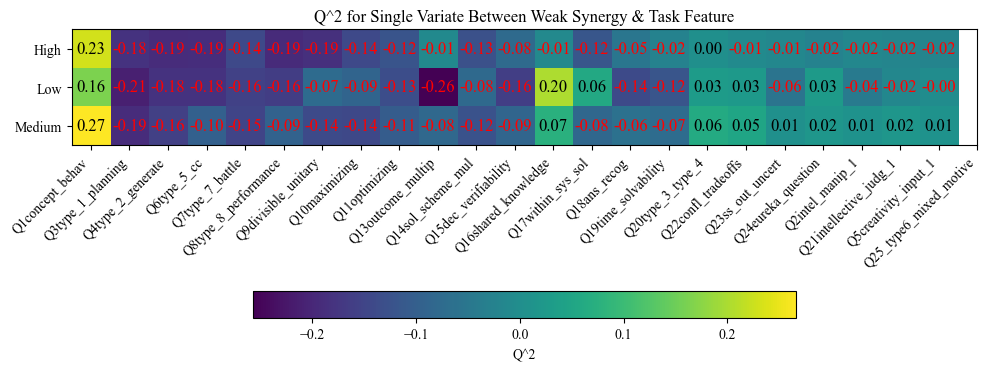

In [46]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("weak_synergy", "Weak Synergy")

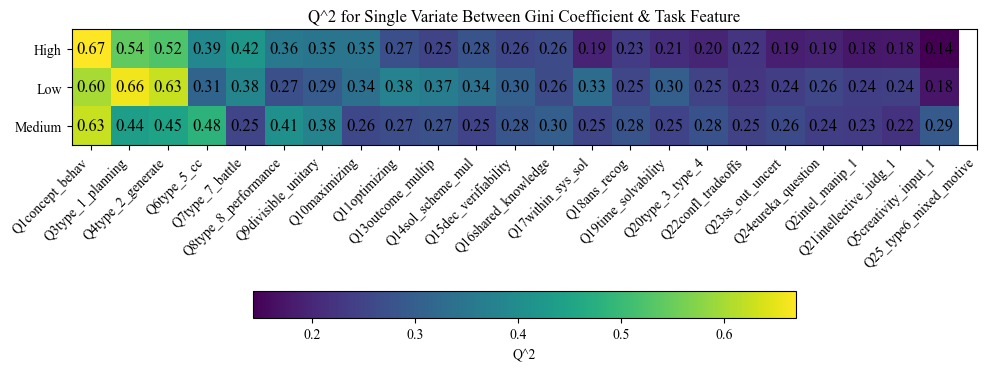

In [47]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("gini_coefficient_sum_num_messages", "Gini Coefficient")

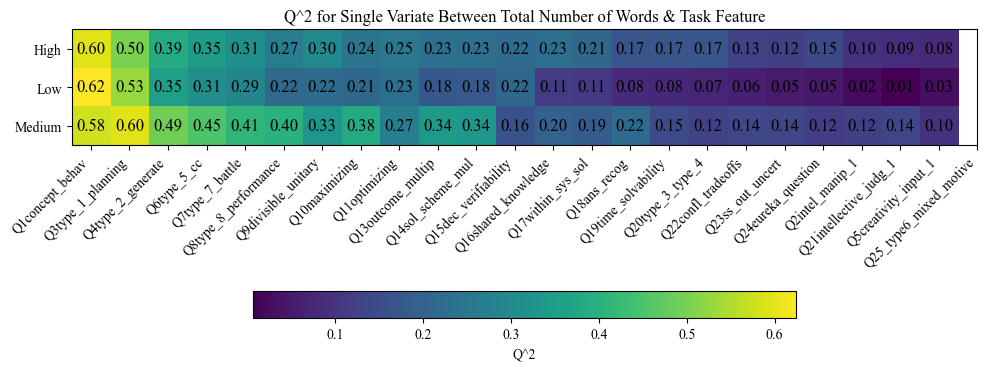

In [48]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("sum_num_words", "Total Number of Words")

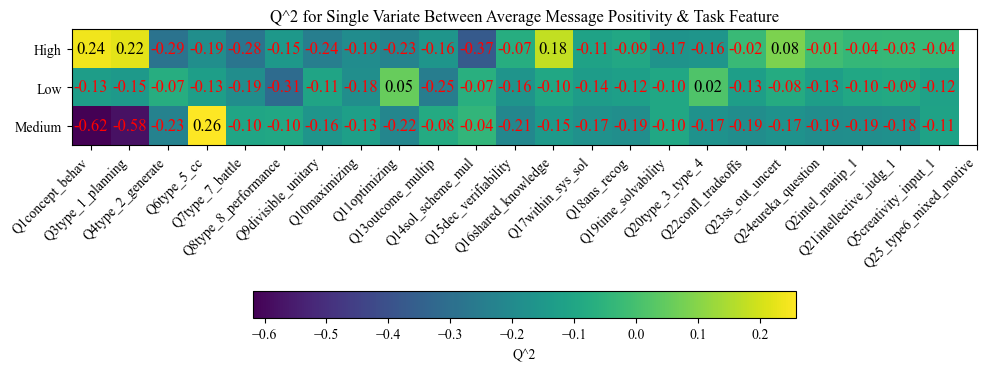

In [49]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("average_positive_bert", "Average Message Positivity")

>  heatmap with x task features and y outcome (synegy, gini) and avging over task complexity.. x axis ordered by avg q^2 across outcomes

#### NOTE: this code should be run after grouping ONLY by "task_name" (and not by playerCount or complexity)
Otherwise, it weights each group evenly (rather than by the number of observations in each group)

In [50]:
aggregated_performance_by_task = grouped_performance_with_task_cols.groupby(GROUPING_COLS)[["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"] + list(task_cols_to_use)].agg("mean").reset_index()
if("complexity" in GROUPING_COLS):
    aggregated_performance_by_task = pd.concat([pd.get_dummies(aggregated_performance_by_task["complexity"], dtype=int), aggregated_performance_by_task], axis = 1) 

In [51]:
aggregated_performance_by_task.to_csv('aggregated_performance_by_task.csv', index = False)

In [52]:
q_2_for_all_dvs = []
dvs = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
for dv in dvs:
    within_dv_arr = []
    for col in task_cols_to_use:
        # get the q2 for each
        q2 = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[col])
        within_dv_arr.append(q2)

    q_2_for_all_dvs.append(within_dv_arr)

In [53]:
q2_by_dv_df = pd.DataFrame(q_2_for_all_dvs, columns=task_cols_to_use, index = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"])
# sort by average
q2_by_dv_df = q2_by_dv_df.reindex(q2_by_dv_df.mean().sort_values(ascending=False).index, axis=1)
# filter for cols in which the min q^2 is above 0.1 --- otherwise we have too many negative q^2's
# q2_by_dv_df = q2_by_dv_df.loc[:, q2_by_dv_df.max() > 0.1]

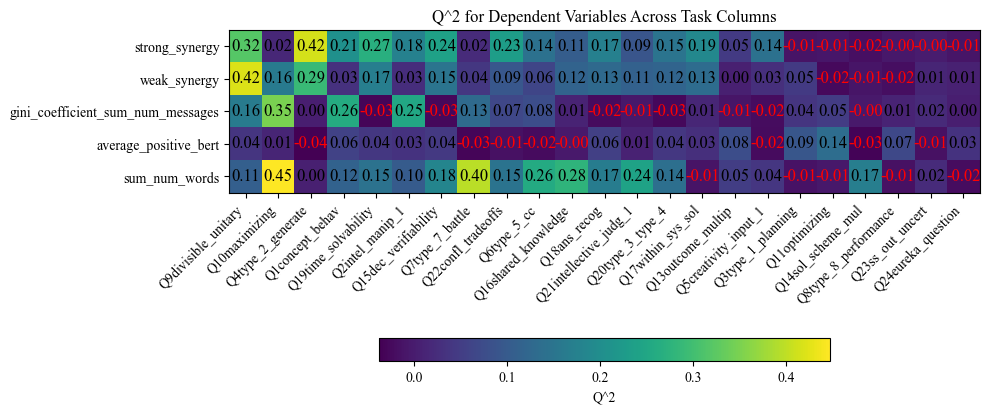

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(q2_by_dv_df, cmap='viridis')  # Set your preferred colormap

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(q2_by_dv_df.columns)))
ax.set_xticklabels(q2_by_dv_df.columns, rotation=45, ha="right")

ax.set_yticks(np.arange(len(dvs)))
ax.set_yticklabels(dvs)

# Loop over data dimensions and create text annotations
for i in range(len(dvs)):
    for j in range(len(q2_by_dv_df.columns)):
        value = q2_by_dv_df.iloc[i, j]
        color = 'black' if value >= 0 else 'red'
        ax.text(j, i, f'{value:.2f}', ha="center", va="center", color=color, fontsize=12)  # Adjust fontsize as needed

ax.set_title("Q^2 for Dependent Variables Across Task Columns")

# Add shorter and horizontal colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink=0.6)
cbar.set_label('Q^2')

fig.tight_layout()
plt.show()

## Q^2 of Regressions with Different Numbers of features
x-axis --> number of features of the task space included
y-axis --> Q^2

i.e.
x=1; y= avg(Q^2) across all features because you fit
x=2; y = Q^2 of a model with two features.. avg over all pairs of features…
etc

In [55]:
# dvs = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
# dv_output_dict = {}
# for dv in dvs:
#     dv_output_dict[dv] = []
#     for num_features in range(1, len(task_cols_to_use)+1):
#         print("Now running models for " + str(num_features) + " features...")
#         feature_combinations = list(itertools.combinations(task_cols_to_use, num_features))

#         # randomly sample up to 1,000 of the combinations, since there are too many
#         random.shuffle(feature_combinations)
#         feature_combinations = feature_combinations[:1000]

#         q2_for_feature_num = []

#         # Parallelize the calculation of q2 for each combination
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             params_list = [(dv, combination) for combination in feature_combinations]
#             q2_for_feature_num = list(executor.map(calculate_q2_for_combination, params_list))

#         dv_output_dict[dv].append(q2_for_feature_num)

### Different versions of features, selecting the "best" feature 1 at a time

In [56]:
def top_n_q2_for_index(index, n):
    top_columns = q2_by_dv_df.loc[index].nlargest(n).index.tolist()
    return top_columns

In [57]:
top_n_q2_for_index("strong_synergy", 4)

['Q4type_2_generate',
 'Q9divisible_unitary',
 'Q19time_solvability',
 'Q15dec_verifiability']

In [58]:
top_n_q2_for_index("weak_synergy", 4)

['Q9divisible_unitary',
 'Q4type_2_generate',
 'Q19time_solvability',
 'Q10maximizing']

In [59]:
top_n_q2_for_index("gini_coefficient_sum_num_messages", 4)

['Q10maximizing', 'Q1concept_behav', 'Q2intel_manip_1', 'Q9divisible_unitary']

In [60]:
top_n_q2_for_index("average_positive_bert", 4)

['Q11optimizing',
 'Q3type_1_planning',
 'Q13outcome_multip',
 'Q8type_8_performance']

In [61]:
top_n_q2_for_index("sum_num_words", 4)

['Q10maximizing', 'Q7type_7_battle', 'Q16shared_knowledge', 'Q6type_5_cc']

In [62]:
if("complexity" in GROUPING_COLS and "playerCount" in GROUPING_COLS):

    dvs = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
    dv_output_dict_best = {}
    for dv in dvs:
        dv_output_dict_best[dv] = []
        for num_features in range(1, len(task_cols_to_use)+1):
            print("Now running models for " + str(num_features) + " features...")
            # select the best model by choosing the top features in terms of univariate q^2
            top_features = top_n_q2_for_index(dv, num_features)
            # also control for the playerCount and complexity in the model
            q2 = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[top_features + ["playerCount", "Low", "Medium"]])

            dv_output_dict_best[dv].append(q2)

Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4 features...
Now running models for 5 features...
Now running models for 6 features...
Now running models for 7 features...
Now running models for 8 features...
Now running models for 9 features...
Now running models for 10 features...
Now running models for 11 features...
Now running models for 12 features...
Now running models for 13 features...
Now running models for 14 features...
Now running models for 15 features...
Now running models for 16 features...
Now running models for 17 features...
Now running models for 18 features...
Now running models for 19 features...
Now running models for 20 features...
Now running models for 21 features...
Now running models for 22 features...
Now running models for 23 features...
Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4

In [63]:
dv_output_dict_best

{'strong_synergy': [0.3734183483706681,
  0.39481967983788424,
  0.6797781847636598,
  0.7589481964164664,
  0.7528128187738465,
  0.7452895371985546,
  0.7400201453944371,
  0.7341103695712932,
  0.7505881838555295,
  0.7505881838555301,
  0.7505881838555296,
  0.7505881838555304,
  0.7505881838555305,
  0.7505592664051003,
  0.750632287761509,
  0.7505881838555303,
  0.7505774997894823,
  0.750650345634786,
  0.7507097021678244,
  0.7507187711445265,
  0.7505325695566594,
  0.7507085848104538,
  0.7493706287861569],
 'weak_synergy': [0.4027456548444309,
  0.4191092435561855,
  0.5666104473863012,
  0.5532530336221071,
  0.5651997855388708,
  0.6242589601784052,
  0.6217617112026045,
  0.7240713848161126,
  0.7216718558602273,
  0.7216718558602269,
  0.7216718558602275,
  0.7216718558602269,
  0.7217391507597437,
  0.7214992248157309,
  0.7213196320524913,
  0.7218051546873567,
  0.720875576220053,
  0.7209743330156457,
  0.721517862610094,
  0.7212421416631686,
  0.7209148209641665,


In [64]:
df_q2_means_for_feature = pd.DataFrame()
for key in dv_output_dict_best.keys():
    means = [np.mean(sublist) for sublist in dv_output_dict_best[key]]
    df_q2_means_for_feature[key] = means

df_q2_stds_for_feature = pd.DataFrame()
for key in dv_output_dict_best.keys():
    std = [np.std(sublist) for sublist in dv_output_dict_best[key]]
    df_q2_stds_for_feature[key] = std

In [65]:
df_q2_means_for_feature

,strong_synergy,weak_synergy,gini_coefficient_sum_num_messages,average_positive_bert,sum_num_words
0,0.373418,0.402746,0.675291,0.063287,0.639186
1,0.394820,0.419109,0.729386,0.088732,0.666500
2,0.679778,0.566610,0.725305,0.060041,0.657261
3,0.758948,0.553253,0.750642,0.026054,0.664796
4,0.752813,0.565200,0.749379,-0.018816,0.668048
5,0.745290,0.624259,0.741965,-0.028948,0.676414
6,0.740020,0.621762,0.746443,-0.020542,0.713857
7,0.734110,0.724071,0.760879,0.080453,0.715732
8,0.750588,0.721672,0.775637,0.080778,0.749999
9,0.750588,0.721672,0.775637,0.080778,0.749999


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5000000000000001, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

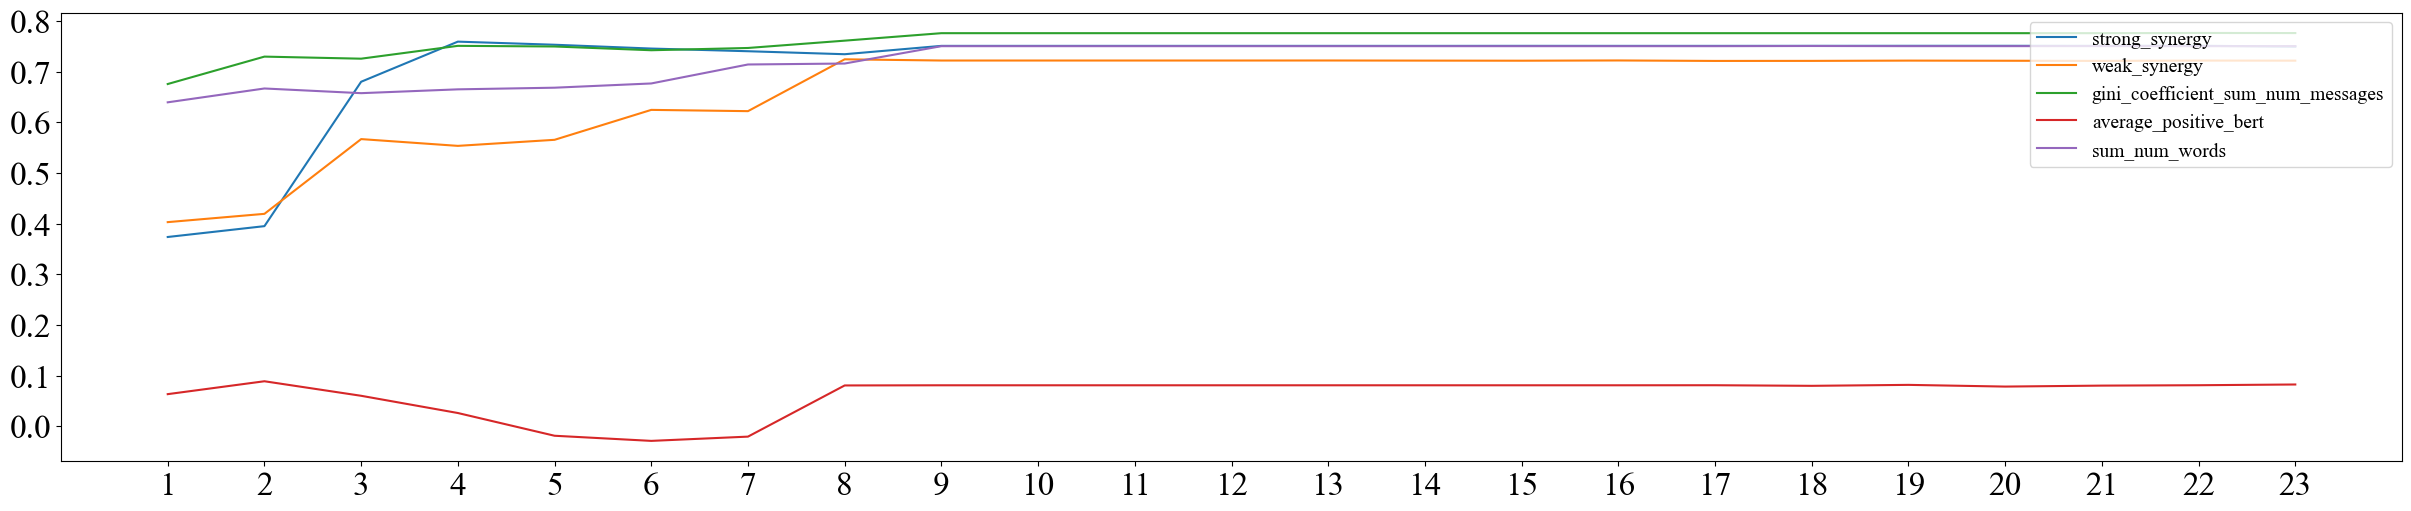

In [181]:
fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

width = 0.16  # the width of the bars
multiplier = 0

for dv in df_q2_means_for_feature.columns:
    means_for_key = df_q2_means_for_feature[dv]
    # stds_for_key = df_q2_stds_for_feature[dv]
    # offset = width * multiplier
    # offset_back = (0.16) * 2.5
    # line plot version
    ax.plot(np.arange(1, 24), means_for_key, label=f'{dv}')
    # bar plot version
    # rects = ax.bar(np.arange(1, 24) + offset - offset_back, means_for_key, width, label=f'{dv}')
    for i in range(1, 24):
        x = i + offset - offset_back
        y = means_for_key[i-1]
        # std = stds_for_key[i-1]
        # ax.errorbar(x, y, std, color="black")
    multiplier += 1

# ax.set_ylim(-4, 4)
ax.legend(fontsize=14, loc='upper right')
plt.xticks(ticks=[_ for _ in range(1, 24)], fontsize=24)
plt.yticks(fontsize=24)

# Exploration of Team Composition Variables
We can aggregate by compositional factors in the same way that we aggregate by task complexity

In [67]:
MEAN_CRT_SCORE = stage_based_data.composition_features["CRT_mean"].mean()
stage_based_data.data["CRT_high"] = np.where(stage_based_data.composition_features["CRT_mean"] >= MEAN_CRT_SCORE, 1, 0)
stage_based_data.data["CRT_low"] = np.where(stage_based_data.composition_features["CRT_mean"] < MEAN_CRT_SCORE, 1, 0)

dvs = ["score", "gini_coefficient_sum_num_messages", "average_positive_bert"]
CRT_based_data = stage_based_data.data.groupby(["task_name", "CRT_high", "CRT_low"])[dvs].agg("mean").reset_index()
CRT_based_data = pd.merge(left = CRT_based_data, right = task_map, on = "task_name", how = "left")

In [68]:
def get_q2_per_CRT_composition(dv, dv_label):
    dv_to_task_q2 = []
    dv_to_task_corr = []
    for CRT_lvl in ["CRT_high", "CRT_low"]:
        dv_by_task_for_crt_level = CRT_based_data[CRT_based_data[CRT_lvl]==1]
        within_crt_arr = []
        wthin_crt_arr_corr = []
        for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
            q2 = get_q2(dv_by_task_for_crt_level[dv], dv_by_task_for_crt_level[col])
            within_crt_arr.append(q2)
            correlation = np.corrcoef(dv_by_task_for_crt_level[dv], dv_by_task_for_crt_level[col])[0][1]
            wthin_crt_arr_corr.append(correlation)

        dv_to_task_q2.append(within_crt_arr)
        dv_to_task_corr.append(wthin_crt_arr_corr)

    plot_q2_heatmap(dv_to_task_q2, ["CRT_high", "CRT_low"], dv_label)
    plot_correlation_heatmap(dv_to_task_corr, ["CRT_high", "CRT_low"], dv_label)

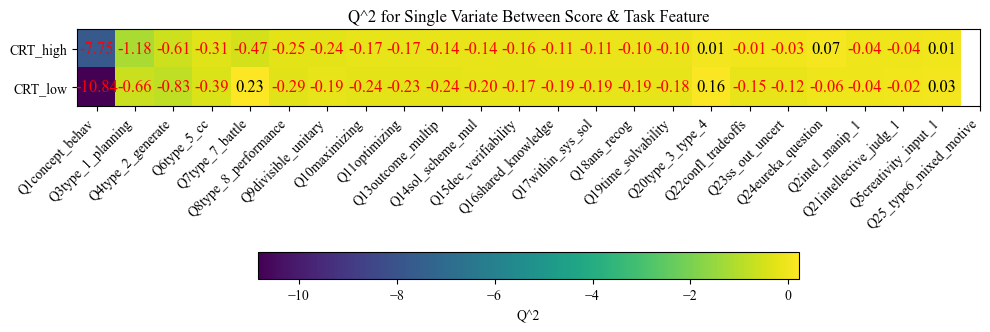

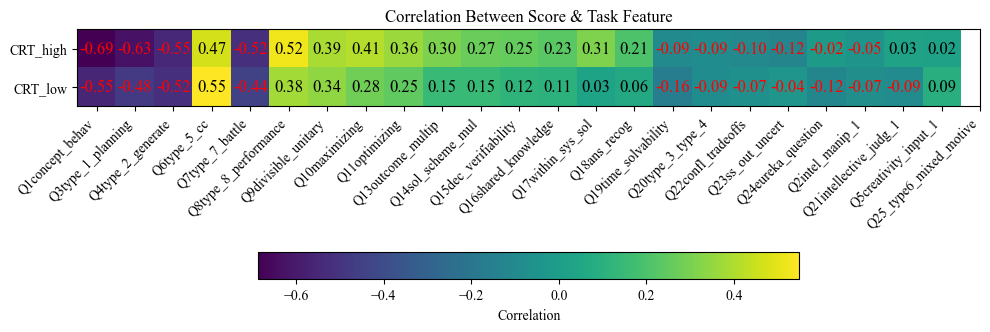

In [69]:
get_q2_per_CRT_composition(dv="score", dv_label="Score")

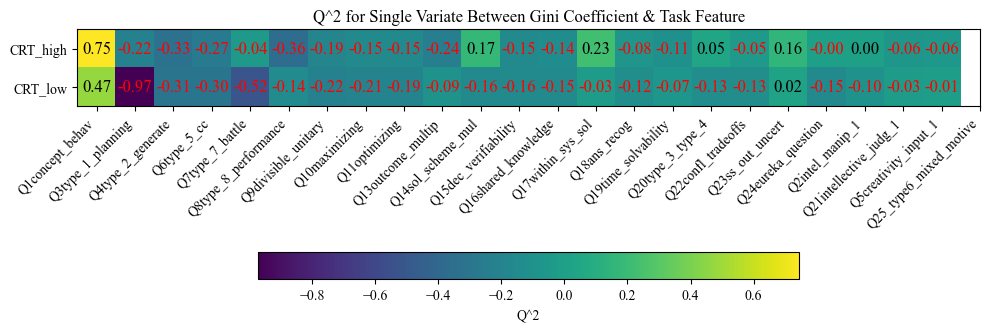

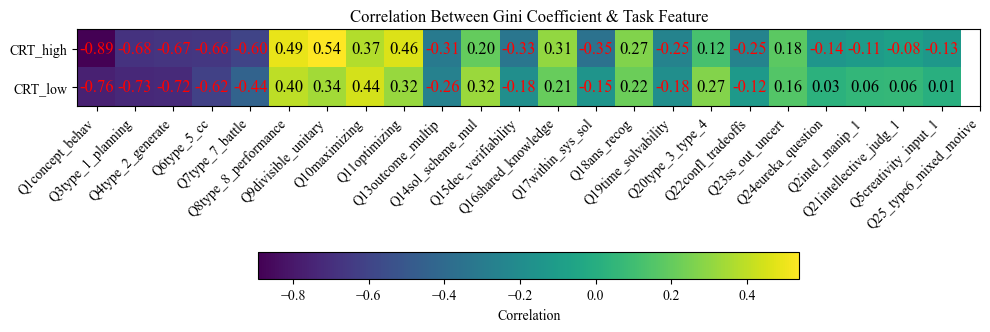

In [70]:
get_q2_per_CRT_composition(dv="gini_coefficient_sum_num_messages", dv_label="Gini Coefficient")

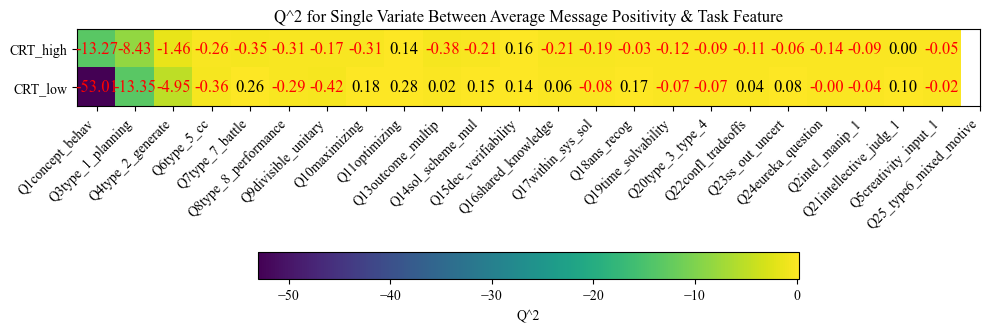

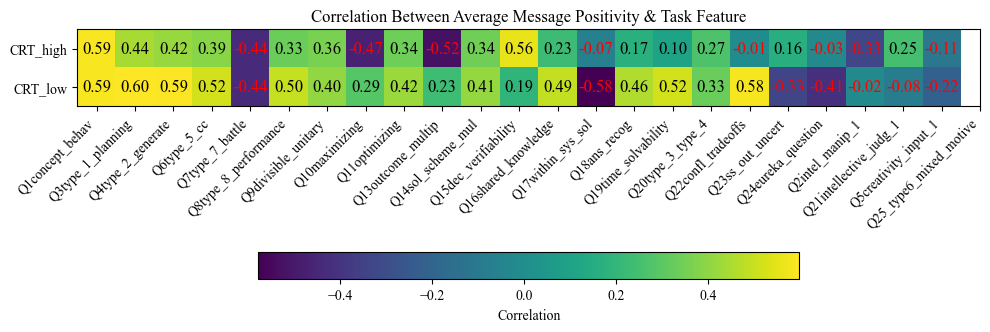

In [71]:
get_q2_per_CRT_composition(dv="average_positive_bert", dv_label="Average Message Positivity")

# "Us versus McGrath" Analysis

### Comparison of Moral Reasoning to Allocating Resources to Programs

In [72]:
mcgrath_colnames = [col for col in task_map.columns if "type" in col]

In [73]:
allocating_moral = task_map[(task_map["task_name"]=="Moral Reasoning (Disciplinary Action Case)") | (task_map["task_name"]=="Allocating resources to programs")]
allocating_moral

,task_name,Q1concept_behav,Q3type_1_planning,Q4type_2_generate,Q6type_5_cc,Q7type_7_battle,Q8type_8_performance,Q9divisible_unitary,Q10maximizing,Q11optimizing,...,Q18ans_recog,Q19time_solvability,Q20type_3_type_4,Q22confl_tradeoffs,Q23ss_out_uncert,Q24eureka_question,Q2intel_manip_1,Q21intellective_judg_1,Q5creativity_input_1,Q25_type6_mixed_motive
10,Moral Reasoning (Disciplinary Action Case),0.0,0.12,0.24,0.88,0.00,0.16,0.166667,0.00,0.08,...,0.080000,0.125000,0.04,1.00,0.571429,0.0,0.012,0.108,0.404,0
22,Allocating resources to programs,0.0,0.44,0.36,1.00,0.04,0.00,0.240000,0.16,0.16,...,0.086957,0.166667,0.08,0.96,0.360000,0.0,0.036,0.196,0.480,0


Key differences on other dimensions

- **Q3type_1_planning**: Is this a "planning" task? In other words, is one of the main purpose(s) of this task to produce a sequence of concrete steps or actions that an individual can follow to achieve some goal?
- **Q23ss_out_uncert**: When doing this task, will the participants have any uncertainty about whether their method or solution will lead to the desired outcome?
- **Q8type_8_performance**: Does the task have an all-or-nothing outcome? In other words, is it sufficient to just meet a particular standard?
- **Q10maximizing** Is the goal (or one of the goals) of this task to try to achieve doing something as much as possible, as many as possible, or as quickly as possible?

In [74]:
# difference between rows
(allocating_moral.iloc[0][1:] - allocating_moral.iloc[1][1:]).sort_values(key=abs, ascending=False)

Q3type_1_planning            -0.32
Q23ss_out_uncert          0.211429
Q8type_8_performance          0.16
Q10maximizing                -0.16
Q17within_sys_sol         0.144348
Q4type_2_generate            -0.12
Q6type_5_cc                  -0.12
Q21intellective_judg_1      -0.088
Q11optimizing                -0.08
Q5creativity_input_1        -0.076
Q9divisible_unitary      -0.073333
Q19time_solvability      -0.041667
Q22confl_tradeoffs            0.04
Q16shared_knowledge          -0.04
Q20type_3_type_4             -0.04
Q14sol_scheme_mul             0.04
Q15dec_verifiability         -0.04
Q13outcome_multip             0.04
Q7type_7_battle              -0.04
Q2intel_manip_1             -0.024
Q18ans_recog             -0.006957
Q1concept_behav                0.0
Q24eureka_question             0.0
Q25_type6_mixed_motive           0
dtype: object

In [75]:
# here's how these two tasks look across all mcGrath columns
allocating_moral[["task_name"] + mcgrath_colnames]

,task_name,Q3type_1_planning,Q4type_2_generate,Q6type_5_cc,Q7type_7_battle,Q8type_8_performance,Q20type_3_type_4,Q25_type6_mixed_motive
10,Moral Reasoning (Disciplinary Action Case),0.12,0.24,0.88,0.00,0.16,0.04,0
22,Allocating resources to programs,0.44,0.36,1.00,0.04,0.00,0.08,0


In [76]:
allocation_moral_mcgrath = allocating_moral[["task_name"] + mcgrath_colnames]

# both of them would be considered Type 5 (Cognitive Conflict)
for i in range(len(allocation_moral_mcgrath)):
    task_vec_mcgrath = allocation_moral_mcgrath.iloc[0][1:]
    print(task_vec_mcgrath.idxmax())

Q6type_5_cc
Q6type_5_cc


In [77]:
# look at some dv's
stage_based_data.dvs.groupby("task").agg("mean").reset_index()

,task,score,speed,efficiency,raw_duration_min,default_duration_min
0,Allocating Resources,64.913793,6.900158,580.312341,2.811993,3.0
1,Divergent Association,90.495483,2.968898,261.945100,2.926658,3.0
2,Guess the Correlation,74.100000,12.840271,999.382531,1.755870,2.0
3,Moral Reasoning,62.500000,11.465764,543.279689,4.437569,5.0
4,Room Assignment,87.202917,20.785565,1916.361707,3.975902,5.0
5,Sudoku,78.711864,13.914606,1362.684040,4.319687,5.0
6,Whac a Mole,36.986985,0.000833,0.030822,2.039582,2.0
7,Wolf Goat Cabbage,89.232558,37.690484,3553.012074,3.124047,5.0
8,Word Construction,48.679104,0.550313,14.557094,3.006662,3.0
9,Writing Story,92.548501,6.152556,493.377618,4.709141,5.0


In [78]:
stage_based_data.data.groupby(["task_name"])[["gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_messages", "sum_num_words"]].agg("mean").reset_index().sort_values("sum_num_messages")

,task_name,gini_coefficient_sum_num_messages,average_positive_bert,sum_num_messages,sum_num_words
6,Whac-A-Mole,0.034503,0.224990,2.368421,12.263158
8,Word construction from a subset of letters,0.068284,0.213040,2.892308,14.107692
1,Divergent Association Task,0.114491,0.262374,5.298851,25.264368
5,Sudoku,0.152894,0.319589,7.483051,37.220339
0,Allocating resources to programs,0.153544,0.258275,7.836207,50.474138
2,Guessing the correlation,0.163716,0.241361,8.376923,37.407692
9,Writing story,0.168322,0.268186,9.738095,84.531746
7,"Wolf, goat and cabbage transfer",0.170308,0.295378,10.170543,47.333333
4,Room assignment task,0.182873,0.348978,10.967480,48.455285
3,Moral Reasoning (Disciplinary Action Case),0.186328,0.216987,12.400000,92.976923


### How much do we predict, versus how much McGrath alone predicts?

In [79]:
# remove type 6, as it is not relevant for our data
mcgrath_colnames.remove('Q25_type6_mixed_motive')

In [80]:
mcgrath_colnames

['Q3type_1_planning',
 'Q4type_2_generate',
 'Q6type_5_cc',
 'Q7type_7_battle',
 'Q8type_8_performance',
 'Q20type_3_type_4']

In [81]:
# let's do this for a single mcgrath bucket
mcgrath_categorical_buckets = {}

for i in range(len(aggregated_performance_by_task)):
    task_vec_mcgrath = aggregated_performance_by_task[mcgrath_colnames].iloc[i][1:]
    task_name = aggregated_performance_by_task.iloc[i]["task_name"]
    type = task_vec_mcgrath.idxmax()
    type_val = task_vec_mcgrath[type]
    if type == "Q20type_3_type_4":
        type = "type_3_intellective" if type_val > 0.5 else "type_4_decision_making"

    mcgrath_categorical_buckets[task_name] = type

In [82]:
# TODO --- still verify these with manual categorical classification
mcgrath_categorical_buckets

{'Allocating resources to programs': 'Q6type_5_cc',
 'Divergent Association Task': 'Q4type_2_generate',
 'Guessing the correlation': 'type_3_intellective',
 'Moral Reasoning (Disciplinary Action Case)': 'Q6type_5_cc',
 'Room assignment task': 'type_3_intellective',
 'Sudoku': 'type_3_intellective',
 'Whac-A-Mole': 'type_4_decision_making',
 'Wolf, goat and cabbage transfer': 'type_3_intellective',
 'Word construction from a subset of letters': 'Q4type_2_generate',
 'Writing story': 'Q4type_2_generate'}

In [83]:
# by manual inspection, this one is wrong
mcgrath_categorical_buckets["Writing story"] = "Q8type_8_performance"

In [84]:
mcgrath_df = pd.DataFrame({
    "task_name": mcgrath_categorical_buckets.keys(),
    "mcgrath_category": mcgrath_categorical_buckets.values()
})

mcgrath_df_categorical = pd.concat([mcgrath_df["task_name"], pd.get_dummies(mcgrath_df["mcgrath_category"], dtype= int).add_suffix('_cat')], axis = 1)

In [85]:
aggregated_performance_by_task = aggregated_performance_by_task.merge(mcgrath_df_categorical, on = "task_name")

In [86]:
mcgrath_categorical = [col for col in aggregated_performance_by_task.columns if "_cat" in col]

In [87]:
dvs = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
dv_output_dict_comparison = {}
for dv in dvs:
    dv_output_dict_comparison[dv] = {}
    dv_output_dict_comparison[dv]["mcgrath_continuous"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[mcgrath_colnames + ["playerCount", "Low", "Medium"]])
    dv_output_dict_comparison[dv]["mcgrath_categorical"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[mcgrath_categorical + ["playerCount", "Low", "Medium"]])
    dv_output_dict_comparison[dv]["all_features"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[list(task_cols_to_use) + ["playerCount", "Low", "Medium"]])

In [88]:
dv_output_dict_comparison

{'strong_synergy': {'mcgrath_continuous': 0.7035405050612757,
  'mcgrath_categorical': 0.5906449523549743,
  'all_features': 0.7511001164697446},
 'weak_synergy': {'mcgrath_continuous': 0.5083221066288041,
  'mcgrath_categorical': 0.18048762239869043,
  'all_features': 0.7216659824869684},
 'gini_coefficient_sum_num_messages': {'mcgrath_continuous': 0.6626052310103994,
  'mcgrath_categorical': 0.7740462275396204,
  'all_features': 0.7756804266379602},
 'average_positive_bert': {'mcgrath_continuous': -0.13101114557635918,
  'mcgrath_categorical': 0.042094867213585796,
  'all_features': 0.08084514205693849},
 'sum_num_words': {'mcgrath_continuous': 0.6675249915164354,
  'mcgrath_categorical': 0.6549903160595503,
  'all_features': 0.7507816694956718}}

# Q^2 Plot by Number of Tasks

> ok - can you produce a plot of Q^2 on the y axis and on the x axis is varying the number of tasks in the data.. if we had 2 tasks only, 3 tasks, up to 10 tasks

In [136]:
tasks_unique = set(tasks)

In [164]:
if("complexity" in GROUPING_COLS and "playerCount" in GROUPING_COLS):

    dvs = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
    q2_by_task_output_dict = {}
    for dv in dvs:
        q2_by_task_output_dict[dv] = {}

        for num_tasks in range(1, len(tasks_unique)+1):
            print("Now running models for " + str(num_tasks) + " tasks...")
            q2_by_task_output_dict[dv][str(num_tasks)] = []

            # randomly select which tasks
            all_possible_task_combos = list(itertools.combinations(tasks_unique, num_tasks))

            N_SAMPLES = 10 # sample from the random possibilities
            task_samples = random.choices(all_possible_task_combos, k=N_SAMPLES)

            # filter down to only these tasks
            for sample in task_samples:
                task_filtered_df = aggregated_performance_by_task[aggregated_performance_by_task["task_name"].isin(sample)]
                q2 = get_q2(task_filtered_df[dv], task_filtered_df[top_features + ["playerCount", "Low", "Medium"]])
                q2_by_task_output_dict[dv][str(num_tasks)].append(q2)

Now running models for 1 tasks...
Now running models for 2 tasks...
Now running models for 3 tasks...
Now running models for 4 tasks...
Now running models for 5 tasks...
Now running models for 6 tasks...
Now running models for 7 tasks...
Now running models for 8 tasks...
Now running models for 9 tasks...
Now running models for 10 tasks...
Now running models for 1 tasks...
Now running models for 2 tasks...
Now running models for 3 tasks...
Now running models for 4 tasks...
Now running models for 5 tasks...
Now running models for 6 tasks...
Now running models for 7 tasks...
Now running models for 8 tasks...
Now running models for 9 tasks...
Now running models for 10 tasks...
Now running models for 1 tasks...
Now running models for 2 tasks...
Now running models for 3 tasks...
Now running models for 4 tasks...
Now running models for 5 tasks...
Now running models for 6 tasks...
Now running models for 7 tasks...
Now running models for 8 tasks...
Now running models for 9 tasks...
Now running 

In [168]:
df_q2_means_for_task = pd.DataFrame()
for key in q2_by_task_output_dict.keys():
    means = [np.mean(sublist) for sublist in q2_by_task_output_dict[key].values()]
    df_q2_means_for_task[key] = means

df_q2_stds_for_task = pd.DataFrame()
for key in q2_by_task_output_dict.keys():
    std = [np.std(sublist) for sublist in q2_by_task_output_dict[key].values()]
    df_q2_stds_for_task[key] = std


(array([-4., -3., -2., -1.,  0.,  1.,  2.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2')])

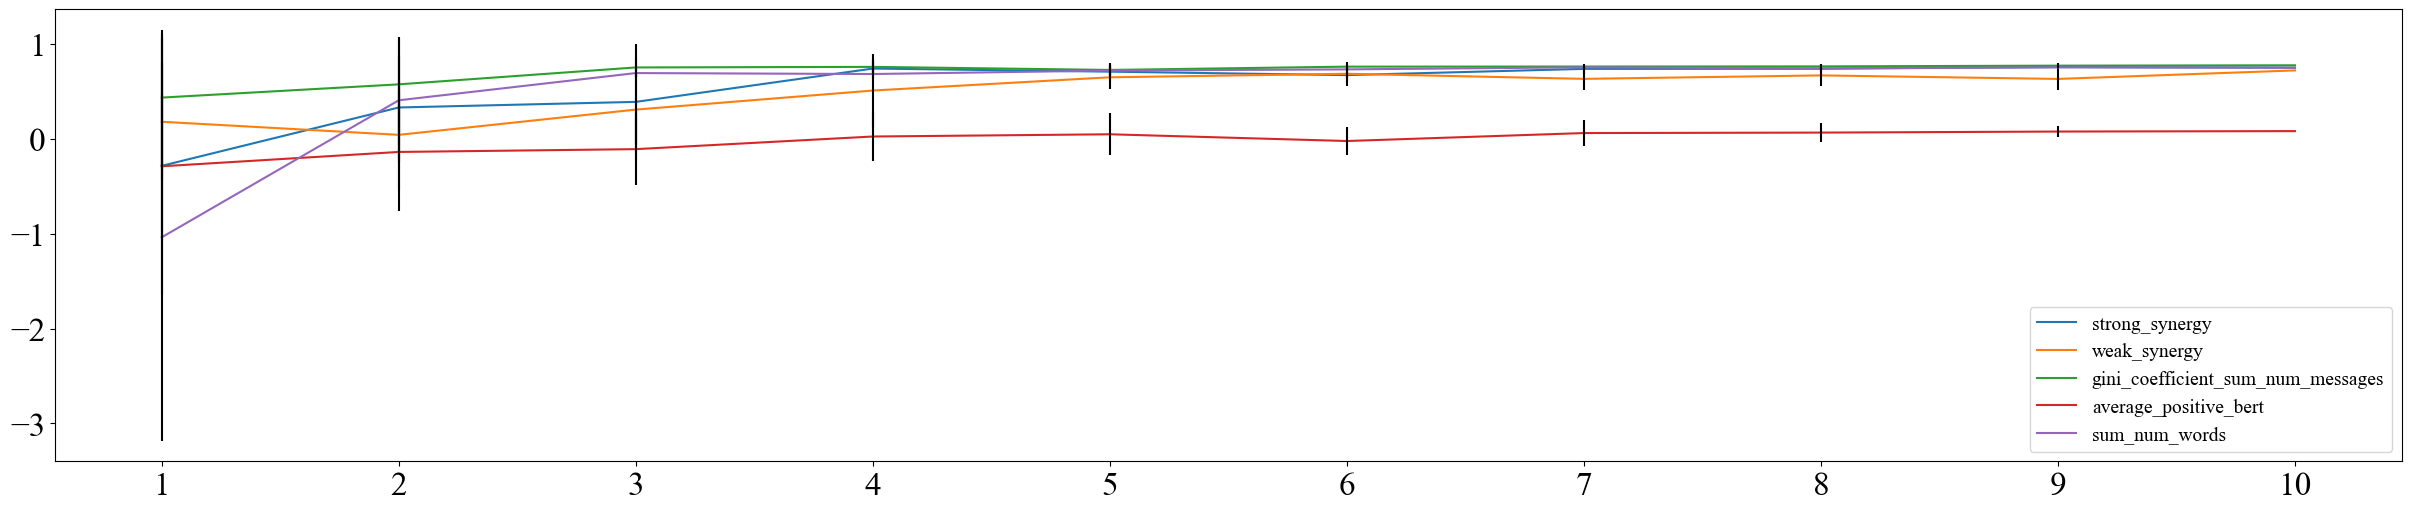

In [191]:
fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

width = 0.16  # the width of the bars
multiplier = 0

for dv in df_q2_means_for_task.columns:
    means_for_key = df_q2_means_for_task[dv]
    stds_for_key = df_q2_stds_for_task[dv]
    # line plot version
    ax.plot(np.arange(1, len(tasks_unique)+1), means_for_key, label=f'{dv}')
    # bar plot version
    # rects = ax.bar(np.arange(1, len(tasks_unique)) + offset - offset_back, means_for_key, width, label=f'{dv}')
    for i in range(1, len(tasks_unique)+1):
        x = i
        y = means_for_key[i-1]
        std = stds_for_key[i-1]
        ax.errorbar(x, y, std, color="black")
    multiplier += 1

# ax.set_ylim(-4, 4)
ax.legend(fontsize=14, loc='lower right')
plt.xticks(ticks=[_ for _ in range(1, len(tasks_unique)+1)], fontsize=24)
plt.yticks(fontsize=24)

# Parallel Coordinates Plot

In [90]:
q2_by_dv_plot = q2_by_dv_df.copy()

# set up a dictionary to track the top feature
top_dict = {
    "dv": list(q2_by_dv_plot.index)
}
for i in range(1, len(q2_by_dv_plot.columns)+1):
    colname = "top_" + str(i)
    top_dict[colname] = []

for dv, row in q2_by_dv_plot.iterrows():

    new_rows = pd.DataFrame()

    for i in range(1, len(q2_by_dv_plot.columns)+1):
        nth_col = row.nlargest(i).index.tolist()[-1]
        colname = "top_" + str(i)

        top_dict[colname].append(nth_col)

In [91]:
progressive_feature_by_q2 = pd.DataFrame(top_dict)

In [115]:
progressive_feature_by_q2_5 = progressive_feature_by_q2[progressive_feature_by_q2.columns[:6]]

In [116]:
flattened_values = progressive_feature_by_q2[progressive_feature_by_q2.columns[1:6]].values.flatten()
category_order = list(set(flattened_values))

for cat in category_order:
    progressive_feature_by_q2_5 = pd.concat([progressive_feature_by_q2_5,
        pd.DataFrame({
            "dv": "NA",
            "top_1": [cat],
            "top_2": [cat],
            "top_3": [cat],
            "top_4": [cat],
            "top_5": [cat]
        })])

In [117]:
top1 = go.parcats.Dimension(values=progressive_feature_by_q2_5.top_1, label="Top Feature")
top2 = go.parcats.Dimension(values=progressive_feature_by_q2_5.top_2, label="Second Feature")
top3 = go.parcats.Dimension(values=progressive_feature_by_q2_5.top_3, label="Third Feature")
top4 = go.parcats.Dimension(values=progressive_feature_by_q2_5.top_4, label="Fourth Feature")
top5 = go.parcats.Dimension(values=progressive_feature_by_q2_5.top_5, label="Fifth Feature")


# Create parcats trace
progressive_feature_by_q2_5['dv_numeric'] = pd.factorize(progressive_feature_by_q2_5['dv'])[0]

In [126]:
color = progressive_feature_by_q2_5.dv_numeric;

fig = go.Figure(data = [go.Parcats(dimensions=[top1, top2, top3, top4, top5],
        line={'color': color},
        hoveron='color',
        labelfont={'size': 15, 'family': 'Times'},
        tickfont={'size': 10, 'family': 'Times'},
        arrangement='freeform')])

fig.show()

# KNN of the Task Map Itself (as a robustness check; 'us versus McGrath?')

In [127]:
X = np.asarray(task_map.drop("task_name", axis = 1)) # task features are the X

In [128]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)

In [129]:
# we can use the `n_neighbors` parameter to look at the N closest neighbors
nearest_neighbors_df = pd.DataFrame(nbrs.kneighbors_graph(X, n_neighbors = 5).toarray(), columns=task_map["task_name"], index=task_map["task_name"])

In [130]:
for name in task_map["task_name"]:
    print(name) 

Categorization problem
Mastermind
Logic Problem
Sudoku
Rank cities by population, rank words by familiarity
Shopping plan
Carter Racing (Experimenterless Version)
Iterative lemonade stand task
Reading the mind in the eyes
Writing story
Moral Reasoning (Disciplinary Action Case)
Word construction from a subset of letters
Carter Racing
Guessing the correlation
Wolf, goat and cabbage transfer
Room assignment task
Arithmetic problem 1
Space Fortress
Visual Oddball Target
The N light bulbs game
Word completion given starting letter
Railroad Route Construction game
Allocating resources to programs
Game of Clue - Terrorist Attack
Word completion given part of word
NASA Moon survival
Image rating
Estimating Factual Quantities
Run a mini business
Recall videos
Search for Oil Task
To evacuate or not to evacuate
Estimating geological metrics
Euclidean traveling salesperson
Reproducing arts
Estimating social quantity
Hidden figures in a picture (Searching Task)
Estimating pages of a book
Abstract 

# Examples of Canonical Tasks
1. Shopping plan (planning)
2. Putting food into categories (Creativity)
3. Arithmetic problem 1 (Intellective)
4. Moral Reasoning (Disciplinary Action Case) (Decision Making)
...etc.

In [131]:
# get nearest neighbors of a particular task
nonzero_indices = lambda df, col: df.index[df[col] != 0].tolist()
nonzero_indices(nearest_neighbors_df, "Word construction from a subset of letters")

['Word construction from a subset of letters',
 'Word completion given starting letter',
 'Putting food into categories']